# Model Training and Fitting

In [137]:
# Un-comment to run git clone from cell, if desired

# !git clone https://github.com/dmst0ut/importforecasting_group2.git
%cd /content/importforecasting_group2/


/content/importforecasting_group2


# Helper functions

## Retrieve data from Database

In [138]:
import sqlite3
import pandas as pd

%cd /content/importforecasting_group2/


def retrieve_data(db_file):
    """ create a database connection to the SQLite database
        specified by db_file
    :param db_file: database file
    :return: data frame
    """

    # Connect to DB
    conn = sqlite3.connect('economic_data.db')
    cursor = conn.cursor()

    try:
      cursor.execute('SELECT id, name, desc FROM series')
      series_data = cursor.fetchall()

      # Create a mapping of series id to (name, desc)
      series_map = {row[0]: (row[1], row[2]) for row in series_data}

      # Fetch from DB
      cursor.execute('''
          SELECT ei.date, ei.series, ei.value
          FROM economic_indicators ei
          JOIN series s ON ei.series = s.id
          ORDER BY ei.date, ei.series;
      ''')

      economic_indicators = cursor.fetchall()

    except Exception as e:
      print(f"An error occurred: {e}")
      conn.close()

    # Close the connection
    conn.close()

    data = []

    for date, series_id, value in economic_indicators:
        name, desc = series_map[series_id]
        data.append({'date': date, 'series': name, 'value': value})

    econ_indicators_long = pd.DataFrame(data)

    # Pivot DF
    econ_indicators = econ_indicators_long.pivot(index='date', columns='series', values='value')

    # Convert the index to datetime
    econ_indicators.index = pd.to_datetime(econ_indicators.index)
    econ_indicators = econ_indicators.asfreq(freq='QS')

    return econ_indicators

/content/importforecasting_group2


## Feature creation

We can approximate the weighted average tariff rate $\tau$ of the US in a given quarter by dividing the government's total revenue from customs duties by total value of imports.

$\tau=\dfrac{customs\_duties}{imports}$

In [139]:
# Feature imports

def create_features(econ_indicators):

    try:
      # Calculate weighted average tariff rate
      econ_indicators['watr'] = econ_indicators['customs_receipts'] / (econ_indicators['imports']*10) # correct scaling
      print("Created new feature: weighted average tariff rate")

      return econ_indicators
    except Exception as e:
      print(f"An error occurred: {e}")





## Programmatically ensure all series are stationary

In [140]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from scipy.interpolate import UnivariateSpline

# Function to check if the series is stationary
def is_stationary(series):
    result = adfuller(series.dropna())
    return result[1] < 0.05  # Return True if the p-value < 0.05, indicating stationarity

# First differencing function
def apply_differencing(series):
    return series.diff().dropna()

# Polynomial regression detrending
def apply_polynomial_trend(series, degree=2):
    X = np.arange(len(series)).reshape(-1, 1)
    y = series.values
    poly = PolynomialFeatures(degree=degree)
    X_poly = poly.fit_transform(X)
    model = LinearRegression().fit(X_poly, y)
    trend = model.predict(X_poly)
    return series - trend

# Spline detrending
def apply_spline_trend(series, s=0.5):
    X = np.arange(len(series))
    spline = UnivariateSpline(X, series, s=s)
    trend = spline(X)
    return series - trend

# Main recursive function to make the series stationary for all columns
def make_stationary(df, max_iter=10, degree=2, s=0.5, exclude_columns=None):
    """
    Makes the time series data stationary for the specified dataframe, excluding certain columns.

    Parameters:
    df (pd.DataFrame): The dataframe to process.
    max_iter (int): The maximum number of iterations for checking stationarity.
    degree (int): The degree of the polynomial for detrending (2 or 3).
    s (float): The smoothing parameter for spline detrending.
    exclude_columns (list): List of columns to exclude from the processing (optional).

    Returns:
    pd.DataFrame, dict: The processed dataframe and the dictionary of differencing counts for each column.
    """
    # If exclude_columns is not provided, use an empty list (no columns to exclude)
    if exclude_columns is None:
        exclude_columns = []

    differencing_counts = {}  # Dictionary to store the number of differences for each column

    # Loop through each column in the dataframe
    for column in df.columns:
        if column in exclude_columns:
            print(f"Excluding column: {column}")
            continue  # Skip the column if it's in the exclude list

        series = df[column]
        iteration = 0
        differencing_count = 0  # Counter to track the number of differencings for this column
        print(f"Processing column: {column}")

        while iteration < max_iter:
            # Check stationarity
            if is_stationary(series):
                print(f"Column {column} is stationary after {iteration} iterations.")
                break

            # Apply differencing
            series = apply_differencing(series)
            differencing_count += 1  # Increment the differencing count

            if is_stationary(series):
                print(f"Column {column} is stationary after differencing at iteration {iteration + 1}")
                break

            # Apply polynomial detrending (quadratic or cubic)
            series = apply_polynomial_trend(series, degree=degree)
            if is_stationary(series):
                print(f"Column {column} is stationary after polynomial detrending at iteration {iteration + 1}")
                break

            # Apply spline detrending
            series = apply_spline_trend(series, s=s)
            if is_stationary(series):
                print(f"Column {column} is stationary after spline detrending at iteration {iteration + 1}")
                break

            iteration += 1  # Only increment iteration after attempting all transformations
            print(f"Iteration {iteration} completed, but series is still non-stationary.")

        # Store the number of differencings applied to this column
        differencing_counts[column] = differencing_count

        # Update the original dataframe with the detrended column
        df[column] = series

    print("Processing complete.")

    # Print the number of differencings applied to each column
    print("\nNumber of differences applied to each column:")
    for column, count in differencing_counts.items():
        print(f"{column}: {count} differences")

    # Return both the processed dataframe and the differencing counts
    return df, differencing_counts



## Create Lagged Features
According to `forecast_horizon` parameter above

In [141]:


def create_lagged_features(df, min_lag=1, max_lag=1):
    """
    Create lagged features for all columns in the DataFrame that are not boolean.
    """
    # Filter columns to exclude boolean types
    non_bool_columns = df.select_dtypes(exclude='bool').columns

    # Create lagged features only for non-boolean columns
    for col in non_bool_columns:
        for i in range(min_lag, max_lag + 1):
            df[f'{col}_lag_{i}'] = df[col].shift(i)

    return df


In [142]:
# Create lags of stationary series, no less than forecast_horizon
def create_lags(ei_stationary, forecast_horizon=2):
    """
    Create lagged features for all columns in the DataFrame that are not boolean.
    """
    ei_st_lagged = create_lagged_features(ei_stationary.drop(columns = 'customs_receipts'), min_lag=forecast_horizon, max_lag=forecast_horizon+3)

    # Add values of import below forecast horizon, since model can predict based off of its own predictions
    for i in range(1, forecast_horizon):
      ei_st_lagged[f'imports_lag_{i}'] = ei_st_lagged['imports'].shift(i)


    return ei_st_lagged

## Train and fit model
* XGBoost with K-fold cross-validation.
* Regularization from in-built apha option and early-stopping hyper-parameter

In [143]:
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

def train_model(df, df_plot, input_watr=False):

    #====INPUTS====# --------------------------------------------------
    df = df.dropna()
    df_plot = df_plot.dropna()

    FEATURES = [col for col in df.columns if 'lag' in col or (input_watr == True and 'watr' in col)]
    TARGET = 'imports'

    tss = TimeSeriesSplit(n_splits=5)

    model = XGBRegressor(n_estimators = 1000,
                          learning_rate = 1,
                          max_depth = 3,
                          random_state = 42,
                          early_stopping_rounds = 25,
                          alpha = 0.1)

    #==============# --------------------------------------------------

    fig, axs = plt.subplots(5, 1, figsize = (15, 15), sharex = True)

    fold = 0
    preds = []
    scores = []


    for train_index, test_index in tss.split(df):
      # For actual training
      train = df.iloc[train_index]
      test = df.iloc[test_index]

      X_train = train[FEATURES]
      y_train = train[TARGET]
      X_test = test[FEATURES]
      y_test = test[TARGET]

      model.fit(X_train, y_train,
                eval_set = [(X_test, y_test)],
                verbose = True)

      y_pred = model.predict(X_test)
      preds.append(y_pred)
      score = mean_squared_error(y_test, y_pred)
      scores.append(score)

      # For plotting forecat
      train_plot = df_plot.iloc[train_index]
      test_plot = df_plot.iloc[test_index]

      train['imports'].plot(ax = axs[fold], label = 'Training Set', title = f'Fold {fold + 1}')
      test['imports'].plot(ax = axs[fold], label = 'Test Set', title = f'Fold {fold + 1}')
      y_pred = pd.Series(y_pred, index = X_test.index)
      y_pred_cumsum = y_pred.cumsum() + test_plot['imports'].loc[y_pred.index[0]]
      y_pred.plot(ax = axs[fold], label = 'Predicted Test Set', title = f'Fold {fold + 1}')
      plt.legend(['Training', 'Testing', 'Predicted'])

      fold += 1

    return model, preds, scores, FEATURES


## Save model

In [144]:
# Save model
import os

def save_model(model, forecast_horizon, inuput_watr):
  try:
    os.makedirs('models', exist_ok=True)
    model_filename = f'xgb_h{forecast_horizon}t{1 if input_watr else 0}.json'
    model_filepath = os.path.join('models', model_filename)
    model.save_model(model_filepath)
    print(f'Saved model as {model_filepath}')
    print(f'Parameters:\n')
    print(f'Forecast horizon: {forecast_horizon} quarters\n')
    print(f'Manual input of tariff rate: {"Yes" if input_watr else "No"}')
  except Exception as e:
    print(f"An error occurred: {e}")

## Prediction of differences

In [145]:
def add_future_quarters(df, quarters=1):
    if isinstance(df.index, pd.DatetimeIndex) and df.index.freq == 'QS':
      df['future'] = False
      for i in range(1, quarters+1):
        new_index = df.index[-1] + pd.DateOffset(months=3)
        new_row_df = pd.DataFrame({'future':True}, index = [new_index])
        df = pd.concat([df, new_row_df])
        print(f"Added quarter {i}, {new_row_df.index}")
      return df
    else:
        raise ValueError("The index of the DataFrame must be a DatetimeIndex with frequency 'QS'.")




In [146]:
import pandas as pd

def predict_difference(ei_stationary, FEATURES, quarters=1, forecast_horizon=2, input_watr=False, watr_manual=None):
  ei_st_future = add_future_quarters(ei_stationary, quarters=forecast_horizon)
  ei_st_lagged_future = create_lagged_features(ei_st_future, min_lag=forecast_horizon, max_lag=forecast_horizon+3)
  ei_st_lagged_future[ei_st_lagged_future['future'] == True]['watr'] = watr_manual

  # Add values of import below forecast horizon, since model can predict based off of its own predictions
  for i in range(1, forecast_horizon):
    ei_st_lagged_future[f'imports_lag_{i}'] = ei_st_lagged_future['imports'].shift(i)

  if input_watr == True:

    for idx in ei_st_lagged_future[ei_st_lagged_future['future'] == True].index:
      ei_st_lagged_future.loc[idx,'watr'] = watr_manual

    for i in range(forecast_horizon, forecast_horizon+3):
      ei_st_lagged_future[f'watr_lag_{i}'] = ei_st_lagged_future['watr'].shift(i)

  # Loop through all future rows
  for idx in ei_st_lagged_future[ei_st_lagged_future['future'] == True].index:

      # Ensure lagged values in current row are updated
      for i in range(1, forecast_horizon+3):
          ei_st_lagged_future.loc[idx, f'imports_lag_{i}'] = ei_st_lagged_future.loc[idx - pd.DateOffset(months=3*i), 'imports']

      # Predict imports for current row
      row_features = ei_st_lagged_future.loc[idx, FEATURES]
      predicted_imports = model.predict([row_features])[0]  # Make sure to predict a single value

      # Add to df
      ei_st_lagged_future.loc[idx, 'imports'] = predicted_imports

      print(f"Updated imports for {idx} with prediction {predicted_imports}")

  return ei_st_lagged_future

  plt.plot(ei_st_lagged_future[ei_st_lagged_future['future']==False]['imports'])
  plt.plot(ei_st_lagged_future[ei_st_lagged_future['future']==True]['imports'])
  plt.xlim(pd.to_datetime('2022-01-01'), max(ei_st_lagged_future.index))
  plt.legend(['Actual', 'Predicted'])
  plt.show()


## Prediction of actual import levels

In [147]:

import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates

# Predict actual values (not differences)

def predict_actual(econ_indicators_clean, ei_st_lagged_future, forecast_horizon=2):

    ## Create un-differenced data frame
    prediction = add_future_quarters(econ_indicators_clean, quarters=forecast_horizon).loc[:, ['imports', 'future']]
    prediction.tail()

    last_historical_index = prediction[prediction['future'] == False].index[-1]
    last_historical_import = prediction.loc[last_historical_index, 'imports']

    # Calculate the cumulative sum of 'imports' for future rows in 'ei_st_lagged_future'
    cumulative_imports = ei_st_lagged_future[ei_st_lagged_future['future']==True]['imports'].cumsum()

    # Update 'imports' values in 'prediction' for future rows
    for idx, val in cumulative_imports.items():
      prediction.loc[idx, 'imports'] = val + last_historical_import

    return prediction




# Main

In [148]:
# Ask if user wants to input weighted average tariff rate (watr)
input_watr = input("Do you want to manually input a Weighted Average Tariff Rate? (yes/no): ").strip().lower()

# Set input_watr to True if 'yes', False if 'no'
if input_watr == 'yes':
    input_watr = True
    # If true, ask for the value of the weighted average tariff rate
    watr_manual = float(input("Please input the Weighted Average Tariff Rate as a whole number\ne.g., 5% should be 5, not 0.05: "))
    print(f"Weighted Average Tariff Rate (watr) has been set to {watr_manual}.")
else:
    input_watr = False
    watr_manual = None
    print("No Weighted Average Tariff Rate (watr) has been provided.")

# Display the variables
print(f"input_watr: {input_watr}")
print(f"watr_manual: {watr_manual}")
print("Please proceed to the next cell.")


Do you want to manually input a Weighted Average Tariff Rate? (yes/no): yes
Please input the Weighted Average Tariff Rate as a whole number
e.g., 5% should be 5, not 0.05: 25
Weighted Average Tariff Rate (watr) has been set to 25.0.
input_watr: True
watr_manual: 25.0
Please proceed to the next cell.


Created new feature: weighted average tariff rate
Processing column: customs_receipts
Column customs_receipts is stationary after differencing at iteration 1
Processing column: fedfunds
Column fedfunds is stationary after differencing at iteration 1
Processing column: gdp
Column gdp is stationary after 0 iterations.
Processing column: imports
Column imports is stationary after differencing at iteration 1
Excluding column: watr
Processing complete.

Number of differences applied to each column:
customs_receipts: 1 differences
fedfunds: 1 differences
gdp: 0 differences
imports: 1 differences
[0]	validation_0-rmse:20.40430
[1]	validation_0-rmse:23.39612
[2]	validation_0-rmse:23.60250
[3]	validation_0-rmse:23.79790
[4]	validation_0-rmse:23.71678
[5]	validation_0-rmse:23.76001
[6]	validation_0-rmse:23.95675
[7]	validation_0-rmse:23.96930
[8]	validation_0-rmse:23.94764
[9]	validation_0-rmse:23.95972
[10]	validation_0-rmse:23.95266
[11]	validation_0-rmse:23.95696
[12]	validation_0-rmse:23.957

<ipython-input-146-d2b9654a9f4a>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ei_st_lagged_future[ei_st_lagged_future['future'] == True]['watr'] = watr_manual


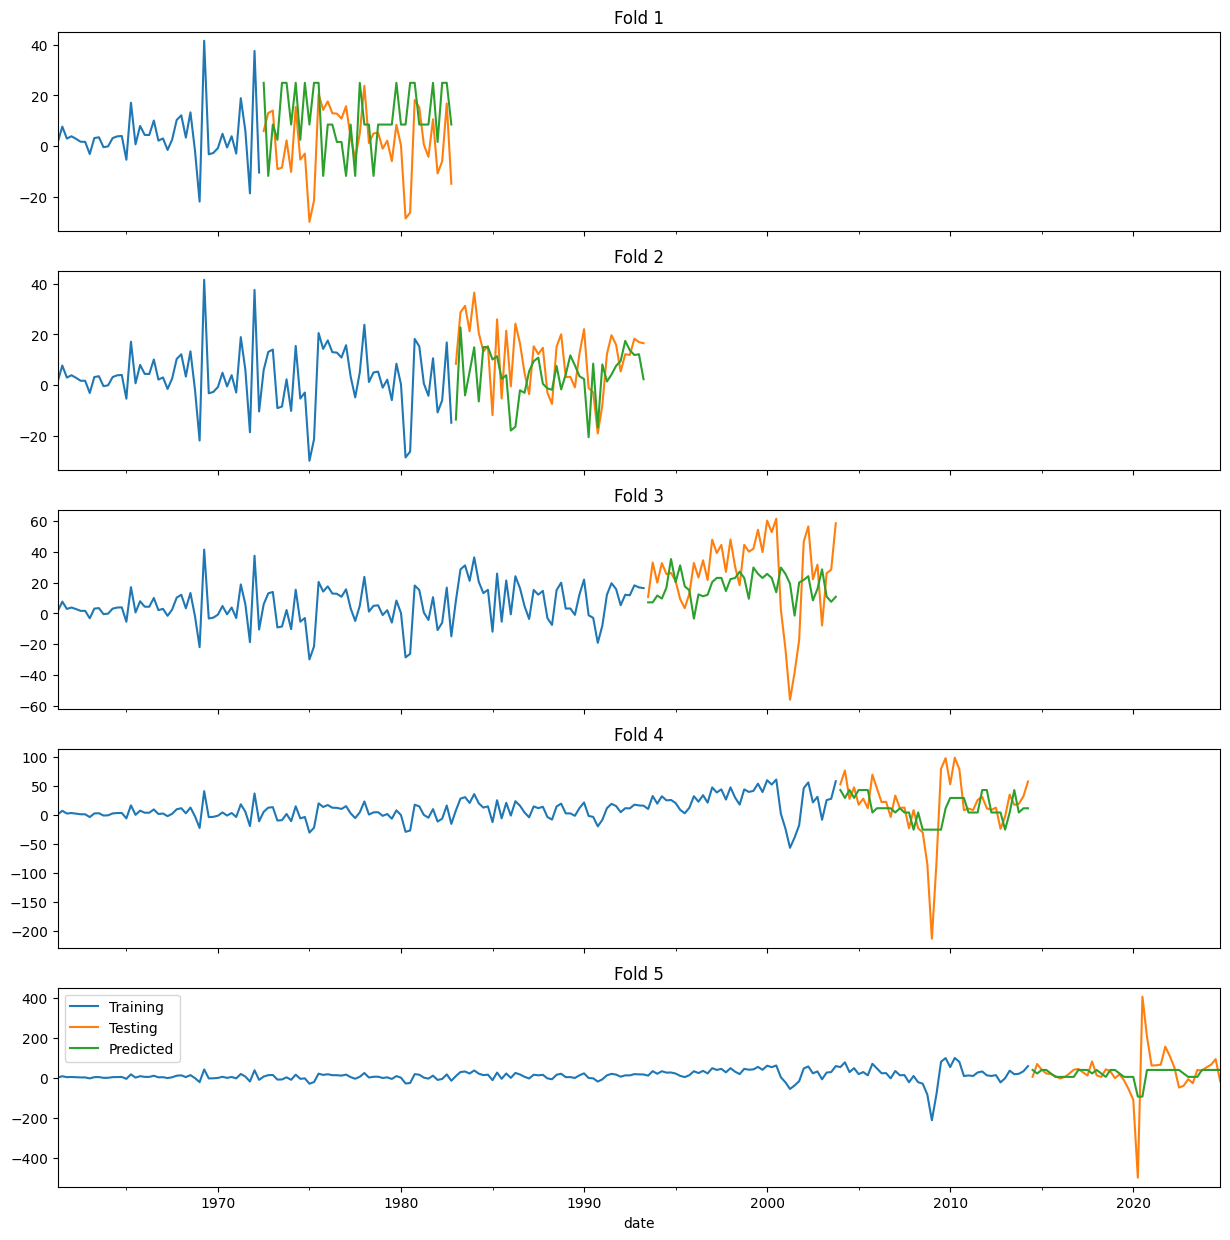

In [149]:
#===USER INPUT===#
# Make sure to run me!
forecast_horizon = 5 # <- Forecast horizon in quarters (including current quarter)

# User inputs from above cell
input_watr = input_watr
watr_manual = watr_manual

#================#

# Retrieve Data from Database
econ_indicators = retrieve_data('economic_data.db')

# Clean, transform, and create features
econ_indicators = create_features(econ_indicators)
econ_indicators_clean = econ_indicators.copy()

ei_stationary, differencing_counts = make_stationary(econ_indicators, exclude_columns='watr')

ei_st_lagged = create_lags(ei_stationary, forecast_horizon=forecast_horizon)

# Train and fit model
model, preds, scores, FEATURES = train_model(ei_st_lagged, econ_indicators, input_watr=input_watr)

save_model(model, forecast_horizon, input_watr)

# Predict differences
ei_st_lagged_future = predict_difference(ei_stationary, FEATURES=FEATURES, quarters=forecast_horizon, forecast_horizon=forecast_horizon, input_watr=input_watr, watr_manual=watr_manual)

# Predict actual levels
prediction = predict_actual(econ_indicators_clean, ei_st_lagged_future, forecast_horizon=forecast_horizon)




<Axes: >

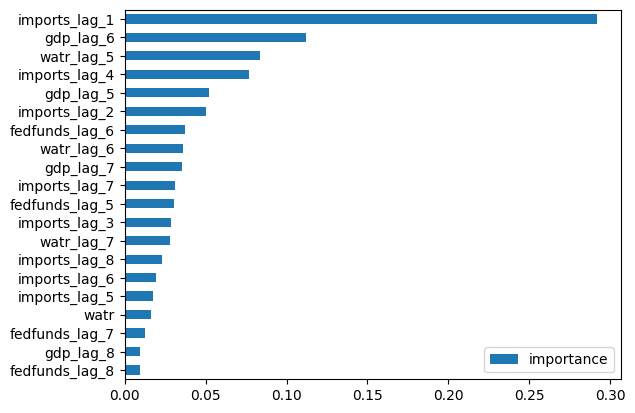

In [150]:
# Model importance

fi = pd.DataFrame(data = model.feature_importances_,
        index = model.feature_names_in_,
        columns = ['importance'])

fi.sort_values(by = 'importance').iloc[1:].plot(kind = 'barh')

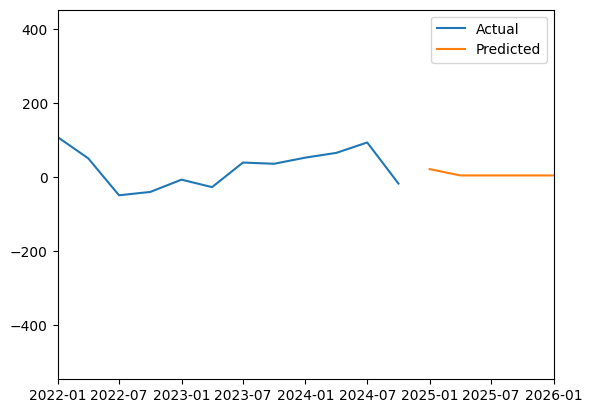

In [151]:
# Plot predicted differences

plt.plot(ei_st_lagged_future[ei_st_lagged_future['future']==False]['imports'])
plt.plot(ei_st_lagged_future[ei_st_lagged_future['future']==True]['imports'])
plt.xlim(pd.to_datetime('2022-01-01'), max(ei_st_lagged_future.index))
plt.legend(['Actual', 'Predicted'])
plt.show()

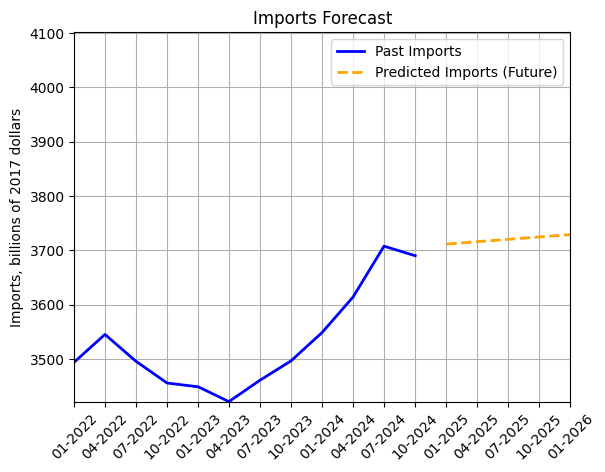

In [152]:
# Plot predicted actual levels

plt.plot(prediction[prediction['future'] == False]['imports'], label='Past Imports', color='blue', linestyle='-', linewidth=2)
plt.plot(prediction[prediction['future'] == True]['imports'], label='Predicted Imports (Future)', color='orange', linestyle='--', linewidth=2)

# Set the x-axis limits
start_date = pd.to_datetime('2022-01-01')
plt.xlim(start_date, max(prediction.index))
plt.ylim(min(prediction[prediction.index>=start_date]['imports']), max(prediction[prediction.index>=start_date]['imports'])*1.1)

# Set the locator for the x-axis to every 3 months (i.e., quarterly)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1, interval=3))  # Every 3 months
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))  # Format as 'Q1 2022', 'Q2 2022', etc.

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adding labels and title
plt.xlabel(None)
plt.ylabel('Imports, billions of 2017 dollars')
plt.title('Imports Forecast')

# Show legend
plt.legend()

# Add grid for better readability
plt.grid(True)

# Display the plot
plt.show()

In [153]:
ei_st_lagged_future.tail(10)

,customs_receipts,fedfunds,gdp,imports,watr,future,customs_receipts_lag_5,customs_receipts_lag_6,customs_receipts_lag_7,customs_receipts_lag_8,...,imports_lag_7,imports_lag_8,watr_lag_5,watr_lag_6,watr_lag_7,watr_lag_8,imports_lag_1,imports_lag_2,imports_lag_3,imports_lag_4
2023-10-01,184.0,0.07,3.2,35.899000,2.274725,False,-7647.0,562.0,11220.0,8265.0,...,107.979,156.047,2.898874,3.074316,3.102836,2.870439,39.132000,-27.237000,-7.017000,-40.18900
2024-01-01,2685.0,0.00,1.6,52.459000,2.316760,False,-10746.0,-7647.0,562.0,11220.0,...,50.696,107.979,2.621608,2.898874,3.074316,3.102836,35.899000,39.132000,-27.237000,-7.01700
2024-04-01,-4141.0,0.00,3.0,65.298000,2.160321,False,-5248.0,-10746.0,-7647.0,562.0,...,-49.249,50.696,2.474760,2.621608,2.898874,3.074316,52.459000,35.899000,39.132000,-27.23700
2024-07-01,7051.0,-0.07,3.1,93.382000,2.296093,False,-3031.0,-5248.0,-10746.0,-7647.0,...,-40.189,-49.249,2.405869,2.474760,2.621608,2.898874,65.298000,52.459000,35.899000,39.13200
2024-10-01,1334.0,-0.61,2.4,-17.600000,2.343198,False,-2964.0,-3031.0,-5248.0,-10746.0,...,-7.017,-40.189,2.293007,2.405869,2.474760,2.621608,93.382000,65.298000,52.459000,35.89900
2025-01-01,NaN,NaN,NaN,21.439770,25.000000,True,184.0,-2964.0,-3031.0,-5248.0,...,-27.237,-7.017,2.274725,2.293007,2.405869,2.474760,-17.600000,93.382000,65.298000,52.45900
2025-04-01,NaN,NaN,NaN,4.368753,25.000000,True,2685.0,184.0,-2964.0,-3031.0,...,39.132,-27.237,2.316760,2.274725,2.293007,2.405869,21.439770,-17.600000,93.382000,65.29800
2025-07-01,NaN,NaN,NaN,4.368753,25.000000,True,-4141.0,2685.0,184.0,-2964.0,...,35.899,39.132,2.160321,2.316760,2.274725,2.293007,4.368753,21.439770,-17.600000,93.38200
2025-10-01,NaN,NaN,NaN,4.368753,25.000000,True,7051.0,-4141.0,2685.0,184.0,...,52.459,35.899,2.296093,2.160321,2.316760,2.274725,4.368753,4.368753,21.439770,-17.60000
2026-01-01,NaN,NaN,NaN,4.368753,25.000000,True,1334.0,7051.0,-4141.0,2685.0,...,65.298,52.459,2.343198,2.296093,2.160321,2.316760,4.368753,4.368753,4.368753,21.43977


In [ ]:
from Get_data.ipynb import